In [1]:
import numpy as np
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler
from sklearn.utils.validation import check_array, check_X_y

import japanize_matplotlib  # noqa
import matplotlib.pyplot as plt
import seaborn as sns  # データ可視化ライブラリ
from lightning.pytorch import seed_everything

plt.style.use("ggplot")
seed_everything(8)


A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.0.1 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "c:\Users\HaruMomozu\Desktop\momozu\ABtesting\.venv\Lib\site-packages\ipykernel_launcher.py", line 18, in <module>
    app.launch_new_instance()
  File "c:\Users\HaruMomozu\Desktop\momozu\ABtesting\.venv\Lib\site-packages\traitlets\config\application.py", line 1075, in launch_instance
    app.start()
  File "c:\Users\HaruMomozu\Desktop\momozu\ABtesting\.venv\Lib\site-packages\ipykernel\kernelapp.py", line 739, in

8

# データの前処理

In [2]:
from scipy import stats
import pandas as pd


df = pd.read_csv(
    R"C:\Users\HaruMomozu\Documents\オンラインデータ\NHANES_age_prediction.csv"
)
df = df.drop(columns=["SEQN", "age_group"])

obj = "BMXBMI"
features_list = [
    "RIDAGEYR",  # 年齢（連続変数）
    "RIAGENDR",  # 性別（1:Male, 2:Female)
    "PAQ605",  # 運動有無(1:日常的に運動する, 2:運動しない)
    "LBXGLU",  # 断食後の血糖値（連続変数）
    "DIQ010",  # 糖尿病の有無(0:なし、1:あり)
    "LBXGLT",  # 口内の健康状態（連続変数）
    "LBXIN",  # 血中インスリン濃度（連続変数）
]


# 外れ値の除去
def remove_outliers_zscore(data, metric, threshold=2):
    z_scores = np.abs(stats.zscore(data[metric]))
    data = data[(z_scores < threshold)]
    return data


df = remove_outliers_zscore(df, obj)

# process_features
from sklearn.preprocessing import StandardScaler


X = df[features_list]
# 数値列の標準化
scaler = StandardScaler()
scaled_features = scaler.fit_transform(X)

X_scaled = pd.DataFrame(scaled_features, columns=features_list)
y = df[obj]  # 目的変数

# 行を詰める
df = df.reset_index(drop=True)

print(df)

      RIDAGEYR  RIAGENDR  PAQ605  BMXBMI  LBXGLU  DIQ010  LBXGLT  LBXIN
0         61.0       2.0     2.0    35.7   110.0     2.0   150.0  14.91
1         26.0       2.0     2.0    20.3    89.0     2.0    80.0   3.85
2         16.0       1.0     2.0    23.2    89.0     2.0    68.0   6.14
3         32.0       1.0     2.0    28.9   104.0     2.0    84.0  16.15
4         38.0       2.0     1.0    35.9   103.0     2.0    81.0  10.92
...        ...       ...     ...     ...     ...     ...     ...    ...
2165      38.0       2.0     2.0    33.5   100.0     2.0    73.0   6.53
2166      61.0       1.0     2.0    30.0    93.0     2.0   208.0  13.02
2167      34.0       1.0     2.0    23.7   103.0     2.0   124.0  21.41
2168      60.0       2.0     2.0    27.4    90.0     2.0   108.0   4.99
2169      26.0       1.0     2.0    24.5   108.0     2.0   108.0   3.76

[2170 rows x 8 columns]


# Wrapperクラス

In [17]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.mixture import GaussianMixture
from sklearn.utils import check_X_y, check_array
import numpy as np


class Wrapper(BaseEstimator, TransformerMixin):
    def __init__(self, n_features_to_select, n_clusters, random_state=None):
        self.n_features_to_select = n_features_to_select  # 選択する特徴量の数
        self.n_clusters = n_clusters  # クラスタ数
        self.random_state = random_state  # 乱数シード

    def FSSEM(self, X, y):
        X, y = check_X_y(X, y)  # データの整合性確認

        self.n_features_ = X.shape[1]  # 特徴量の総数
        self.selected_features_ = []  # 特徴量サブセット初期化

        # 現在選択されている特徴量のインデックスを格納する用
        current_features = []
        # 選択されていない特徴量のインデックスを格納する用
        remaining_features = list(range(X.shape[1]))

        # SFS
        while len(current_features) < self.n_features_to_select:
            best_score = -np.inf  # 最良スコアの初期化（マイナス無限大）
            best_feature = None

            # 追加すべき特徴量を1つ決める
            for feature in remaining_features:
                temp_features = current_features + [
                    feature
                ]  # 現在の特徴量リストに新しい特徴量を加えた仮のリストを作成
                score = self.evaluate_subset(
                    X[:, temp_features], y
                )  # 仮のリストに基づいて評価
                if score > best_score:  # 評価スコアが最良スコアよりも大きいときは更新
                    best_score = score
                    best_feature = feature

            # current_featuresとremaining_featuresの更新
            if best_feature is not None:
                current_features.append(best_feature)
                remaining_features.remove(best_feature)
                self.selected_features_ = current_features
            else:
                break

        # 最終的な選択された特徴量でクラスタリングを実施
        final_features = X[:, self.selected_features_]
        self.final_gmm_ = GaussianMixture(
            n_components=self.n_clusters, random_state=self.random_state
        )
        self.final_gmm_.fit(final_features)

        # データポイントのクラスタリング結果を取得
        self.final_cluster_assignments_ = self.final_gmm_.predict(final_features)

        return self

    def transform(self, X):
        check_array(X)  # Xを検証
        return X[:, self.selected_features_]  # 選択された特徴量だけを抽出して返す

    def evaluate_subset(self, X_subset, y):  # EMクラスタリング
        gmm = GaussianMixture(
            n_components=self.n_clusters, random_state=self.random_state
        )
        gmm.fit(X_subset)

        # GMMのパラメータ
        means = gmm.means_  # 各クラスタの平均ベクトル
        covariances = gmm.covariances_  # 各クラスタの共分散行列
        weights = gmm.weights_  # 各クラスタの混合係数
        overall_mean = np.sum(
            [weights[k] * means[k] for k in range(self.n_clusters)], axis=0
        )
        # クラスタ内分離行列
        S_W = np.sum(
            [weights[k] * covariances[k] for k in range(self.n_clusters)], axis=0
        )

        # クラスタ間分離行列
        S_B = np.sum(
            [
                weights[k] * np.outer(means[k] - overall_mean, means[k] - overall_mean)
                for k in range(self.n_clusters)
            ],
            axis=0,
        )

        # 散乱分離性
        scatter_discriminability = np.trace(np.linalg.inv(S_W).dot(S_B))
        return scatter_discriminability

    def get_feature_index_out(self):
        # 選択された特徴量のインデックスを返す
        return np.array(self.selected_features_)

    def get_final_cluster_assignments(self):
        # 最終的なクラスタリング結果を返す(各データがどのクラスタに属するかの配列)
        return self.final_cluster_assignments_

Wrapperクラス確認

In [18]:
# 特徴量選択のためのインスタンスを作成
n_features_to_select = 3  # 選択したい特徴量の数
n_clusters = 3
fssem = Wrapper(
    n_features_to_select=n_features_to_select, n_clusters=n_clusters, random_state=0
)

# FSSEM
fssem.FSSEM(X_scaled, y)  # 選択された特徴量
selected_features = fssem.get_feature_index_out()
print(f"Selected features indices: {selected_features}")
cluster_label = fssem.get_final_cluster_assignments()
print(f"cluster_label:{cluster_label}")
print(len(cluster_label))

c:\Users\HaruMomozu\Desktop\momozu\ABtesting\.venv\Lib\site-packages\sklearn\base.py:1473: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)


Selected features indices: [1 0 3]
cluster_label:[1 1 0 ... 0 1 0]
2170


# 層化抽出

In [19]:
from abc import ABCMeta, abstractmethod

from numpy.typing import NDArray


class BaseAllocation(metaclass=ABCMeta):  # 抽象基底クラス（ABC）
    # 初期化クラス（n_samples(標本サイズ), H(クラスタ数)）
    def __init__(self, n_samples: int, H: int, random_state: int):
        self.n_samples = n_samples
        self.H = H
        self.random_state = random_state

    @abstractmethod
    def solve(self, X: NDArray, y: NDArray) -> NDArray:
        """標本配分を解く

        Args:
            X (NDArray): データ (N x M)
            y (NDArray): 目的変数 (N)

        Raises:
            NotImplementedError: _description_

        Returns:
            NDArray: 各クラスタの標本数 (H, )

        Note:
            M: 特徴量数
            H: クラスタ数
        """
        # 具象クラスがsolveメゾッドを実装しない場合はNotImpleamentedErrorが発生
        raise NotImplementedError

    def clustering(self, X: NDArray) -> tuple[NDArray, NDArray]:
        """クラスタリングを行う

        Args:
            X (NDArray): データ (N x M)

        Returns:
            NDArray: クラスタラベル (N, ), クラスタサイズ (H, )

        Note:
            N: データ数
            M: 特徴量数
            H: クラスタ数
        """
        cluster_label = fssem.get_final_cluster_assignments()
        # 母集団の各クラスタのサイズを計算
        _, cluster_size = np.unique(cluster_label, return_counts=True)
        # インスタンス変数として設定
        self.cluster_label = cluster_label
        self.N = cluster_size

        return cluster_label, cluster_size.copy()


In [20]:
from numpy.typing import NDArray


# BaseAllocationを継承することでBaseAllocationクラスで定義されたインスタンス変数やメゾッドを利用できる
class RandomAllocation(BaseAllocation):
    # 抽象メゾッドを具象化
    def solve(self, X: NDArray, y: NDArray) -> NDArray:
        """ランダムにn_samplesの標本を選択する"""
        n = np.array([self.n_samples])

        return n  # （例）n=[標本サイズ]

    def clustering(self, X: NDArray) -> tuple[NDArray, NDArray]:
        # cluster_labelのすべての要素は0（すべてのデータを同じクラスタに属させている）
        cluster_label = np.zeros(
            X.shape[0]
        )  # cluster_label = [0,0,0,,...(要素数：データ数）]
        # クラスタサイズ＝データ数
        cluster_size = np.array([len(cluster_label)])  # cluster_size=[データ数]
        return cluster_label, cluster_size


In [21]:
class PropotionalAllocation(BaseAllocation):
    def solve(self, X: NDArray, y: NDArray) -> NDArray:
        """各クラスタ数に比例した標本数で分割する"""
        n: NDArray = np.round(self.N / self.N.sum() * self.n_samples).astype(int)

        if n.sum() > self.n_samples:
            # nの合計がn_samplesより大きい場合は一番標本数が多いクラスタから削る
            n[np.argmax(n)] -= n.sum() - self.n_samples

        return n


In [22]:
class PostStratification(BaseAllocation):
    def solve(self, X: NDArray, y: NDArray) -> NDArray:
        """ランダムにn_samplesの標本を選択する"""
        n = np.array([self.n_samples])

        return n  # （例）n=[標本サイズ]


In [23]:
from typing import Literal, Optional

from numpy.typing import NDArray


class OptimalAllocation(BaseAllocation):
    def __init__(
        self,
        n_samples: int,
        H: int,
        m: NDArray,  # 標本サイズ下限
        M: Optional[NDArray] = None,  # 標本サイズ上限 #Optional(Noneである可能性がある)
        random_state: int = 0,
    ):
        super().__init__(
            n_samples, H, random_state
        )  # 基底クラスBaseAllocation（スーパークラス）の初期化メゾッドを呼び出す
        self.m = m  # 各クラスタの最小標本サイズ (H, )
        self.M = M  # 各クラスタの最大標本サイズ (H, ), (指定しない場合はクラスタサイズ)

    def solve(self, X: NDArray, y: NDArray) -> NDArray:
        # S:クラスタ毎の目的変数のvarianceを要素とする配列 (H, )
        S = np.array([np.var(y[self.cluster_label == h]) for h in range(self.H)])
        d = (self.N**2) * S  # (H, )
        n = self._simple_greedy(n=self.m.copy(), d=d)

        # 制約チェック
        self._check_constraints(n)

        return n

    def _simple_greedy(self, n: NDArray, d: NDArray) -> NDArray:
        M = self.M.copy() if self.M is not None else self.N.copy()

        I = np.arange(self.H)  # noqa #クラスタのインデックス

        while (n.sum() != self.n_samples) and len(I) != 0:
            delta = np.zeros(self.H)
            delta[I] = (d / (n + 1) - d / n)[I]
            h_star = np.argmin(delta[I])
            h_star = I[h_star]

            if n[h_star] + 1 <= M[h_star]:
                n[h_star] = n[h_star] + 1
            else:
                # Iの要素h_starを削除
                I_ = I.tolist()
                I_ = [i for i in I_ if i != h_star]
                I = np.array(I_)  # noqa

        return n

    def _check_constraints(self, n: NDArray):
        assert (
            n.sum() <= self.n_samples
        ), f"Total sample size is over than {self.n_samples}"
        assert np.all(n >= self.m), "Minimum sample size constraint is not satisfied"
        if self.M is not None:
            assert np.all(
                n <= self.M
            ), "Maximum sample size constraint is not satisfied"


In [24]:
import numpy as np
from numpy.typing import NDArray


def estimate_y_mean(n: NDArray, cluster_label: NDArray, y: NDArray) -> NDArray:
    """実際にサンプリングを行って目的変数の平均を推定

    Args:
        n (NDArray): 各クラスタの標本数 (H, )
        cluster_label (NDArray): クラスタラベル (N, )
        y (NDArray): 目的変数 (N, )

    Returns:
        NDArray: 推定された目的変数の平均

    Note:
        N: データ数
        H: クラスタ数
    """
    # cluster_labelからユニークなクラスタラベルを取得し、母集団の各クラスタのサイズNを取得
    N = np.unique(cluster_label, return_counts=True)[1]  # クラスタサイズ (H, )
    weights = N / N.sum()
    y_hat = 0
    for h in range(n.shape[0]):  # n.shape[0]:層の数
        y_cluster = y[cluster_label == h]
        # クラスタ内でランダム n_h サンプリング
        sample: NDArray = np.random.choice(y_cluster, n[h], replace=False)
        y_sample_mean = sample.mean()  # サンプリングした標本の平均
        y_hat += y_sample_mean * weights[h]

    return y_hat


def estimate_y_mean_post(n: NDArray, cluster_label: NDArray, y: NDArray) -> NDArray:
    N = np.unique(cluster_label, return_counts=True)[1]
    weights = N / N.sum()
    y_hat = 0
    indices = np.arange(N.sum())
    y_array = np.array(y.tolist())
    n_indices = np.random.choice(indices, n[0], replace=False)
    n_label = np.array([cluster_label[i] for i in n_indices])
    n_new = np.unique(n_label, return_counts=True)[1]
    for h in range(n_new.shape[0]):
        index = np.where(n_label == h)[0]
        sample = y_array[n_indices[index]]  ##ここ
        y_sample_mean = sample.mean()  # サンプリングした標本の平均
        y_hat += y_sample_mean * weights[h]
    return y_hat


In [25]:
N_SAMPLES = 100  # 標本サイズ
H = n_clusters  # クラスタ数が多すぎるとpropotionalがうまくいかない
N_TRIALS = 1000  # 試行回数
m_VALUE = 2  # 各クラスタの最小標本数
RANDOM_STATE = 0  # 乱数シード

# 戦略を定義
policies: list[BaseAllocation] = [
    RandomAllocation(n_samples=N_SAMPLES, H=H, random_state=RANDOM_STATE),
    PropotionalAllocation(n_samples=N_SAMPLES, H=H, random_state=RANDOM_STATE),
    PostStratification(n_samples=N_SAMPLES, H=H, random_state=RANDOM_STATE),
    OptimalAllocation(
        n_samples=N_SAMPLES,
        H=H,
        random_state=RANDOM_STATE,
        m=np.full(H, m_VALUE),
        M=None,
    ),
]

# それぞれの戦略で各クラスタの標本数を求解
allocations: list[dict] = []  # 各戦略の実行結果が辞書形式で追加される
for policy in policies:
    # policyを用いてXをクラスタリング(_は戻り値の２番目を無視)
    cluster_label, _ = policy.clustering(X_scaled)
    n = policy.solve(X_scaled, y)
    allocations.append(
        {
            "policy": policy.__class__.__name__,
            "n": n,
            "cluster_label": cluster_label,
        }
    )


# 各戦略の標本数に基づいて目的変数の平均を推定
y_hats = []
for random_state in range(N_TRIALS):
    for allocation in allocations:
        if allocation["policy"] == "PostStratification":
            y_hat = estimate_y_mean_post(
                allocation["n"], allocation["cluster_label"], y
            )
        else:
            y_hat = estimate_y_mean(allocation["n"], allocation["cluster_label"], y)
        y_hats.append(
            {
                "policy": allocation["policy"],
                "y_hat": y_hat,
                "random_state": random_state,
            }
        )


(0.0, 100.0)

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


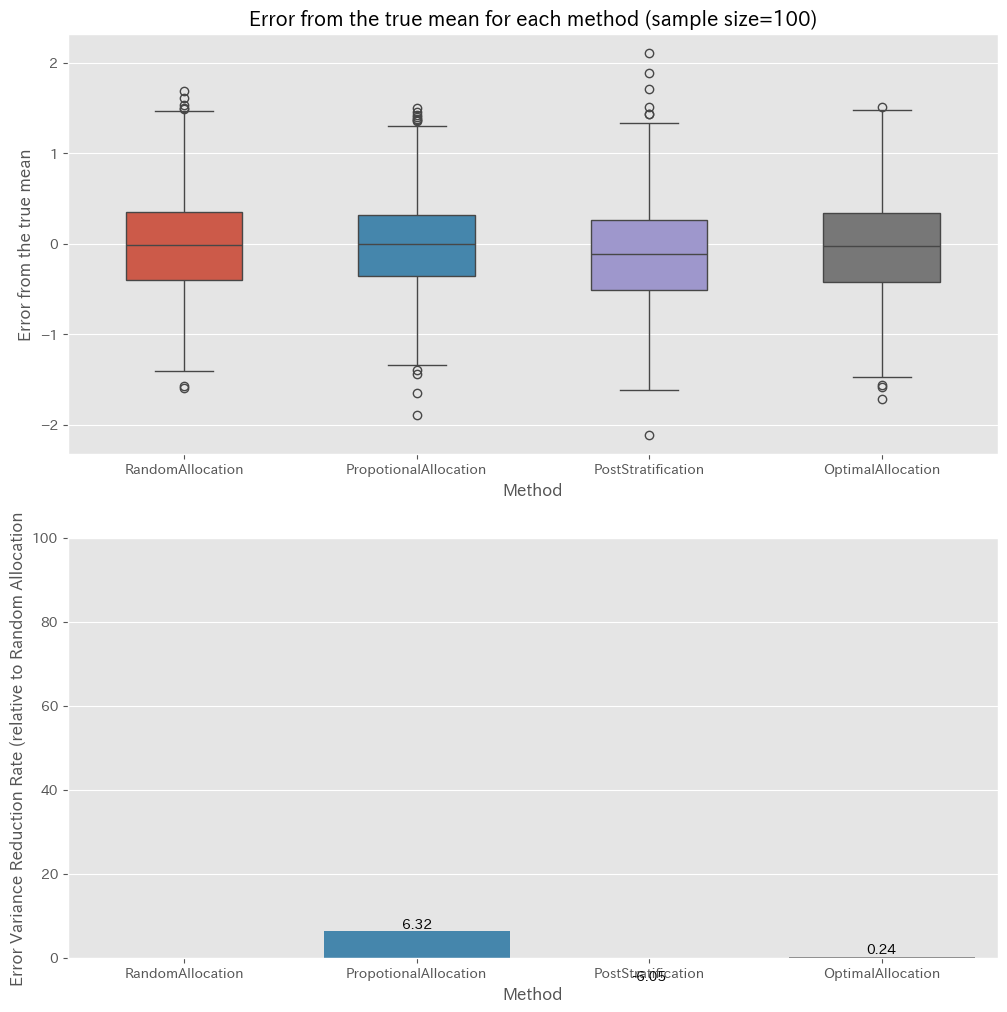

In [27]:
import matplotlib.pyplot as plt
import seaborn as sns

axes: list[plt.Axes]
fig, axes = plt.subplots(2, 1, figsize=(12, 6 * 2))

# 箱ひげ図で誤差の分布を比較
y_hat_df = pd.DataFrame(y_hats)
y_hat_df["error"] = (
    y_hat_df["y_hat"] - y.mean()
)  # 真の平均からの誤差をerrorカラムに追加
sns.boxplot(
    data=y_hat_df,
    y="error",
    x="policy",
    hue="policy",
    ax=axes[0],
    linewidth=1,
    width=0.5,
)
axes[0].set_title(
    "Error from the true mean for each method (sample size={})".format(N_SAMPLES)
)
axes[0].set_ylabel("Error from the true mean")
axes[0].set_xlabel("Method")

# 棒グラフでRandomAllocationに対する誤差分散削減率を比較
# random_allocationの誤差分散
random_allocation_std = y_hat_df[y_hat_df["policy"] == "RandomAllocation"][
    "error"
].var()
# random_allocation以外の誤差分散
non_random_allocation_std = (
    y_hat_df[y_hat_df["policy"] != "RandomAllocation"].groupby("policy")["error"].var()
)
reduction_rate = (
    1 - non_random_allocation_std / random_allocation_std
) * 100  # 削減率 (%)
## policyの順番をpoliciesの順番に調整
reduction_rate = reduction_rate.reindex(
    [policy.__class__.__name__ for policy in policies]
)
sns.barplot(
    x=reduction_rate.index,
    y=reduction_rate.values,
    ax=axes[1],
    hue=reduction_rate.index,
)
# 棒グラフの上に値を表示
for i, v in enumerate(reduction_rate.values):
    axes[1].text(i, v, f"{v:.2f}", ha="center", va="bottom")
axes[1].set_ylabel("Error Variance Reduction Rate (relative to Random Allocation")
axes[1].set_xlabel("Method")
axes[1].set_ylim(0, 100)


In [28]:
RandomAllocation_df = y_hat_df[y_hat_df["policy"] == "RandomAllocation"]
var_for_RandomAllocation = RandomAllocation_df["error"].var()
PropotionalAllocation_df = y_hat_df[y_hat_df["policy"] == "PropotionalAllocation"]
var_for_PropotionalAllocation = PropotionalAllocation_df["error"].var()
PostStratification_df = y_hat_df[y_hat_df["policy"] == "PostStratification"]
var_for_PostStratification = PostStratification_df["error"].var()
OptimalAllocation_df = y_hat_df[y_hat_df["policy"] == "OptimalAllocation"]
var_for_OptimalAllocation = OptimalAllocation_df["error"].var()

print("Var")
print("Random Allocation:", var_for_RandomAllocation)
print("PropotionalAllocation:", var_for_PropotionalAllocation)
print("PostStratification:", var_for_PostStratification)
print("OptimalAllocation:", var_for_OptimalAllocation)


Var
Random Allocation: 0.3000401965965966
PropotionalAllocation: 0.2810645732914614
PostStratification: 0.3181909560139565
OptimalAllocation: 0.29930617296670087
